
This tutorial is adopted from [Python-Engineer's Pytorch Tutorial](https://www.python-engineer.com/) | [Video](https://www.youtube.com/watch?v=pDdP0TFzsoQ&feature=emb_logo)

Good reading links: 
- [CMU's CS231 Course](http://cs231n.github.io/convolutional-networks/)

Convolutional neural network is used to train [CIFAR-10 dataset](https://www.cs.toronto.edu/~kriz/cifar.html). It is implemented in PyTorch 

### What does it consists of? 
The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images.

The dataset is divided into five training batches and one test batch, each with 10000 images. The test batch contains exactly 1000 randomly-selected images from each class. The training batches contain the remaining images in random order, but some training batches may contain more images from one class than another. Between them, the training batches contain exactly 5000 images from each class. 

### What's a CNN? 

Same as NN but are optimized for image analysis. Before training the weights and biases in the full-connected layer the training data is 'screened and filtered' to tease out relevant features of each image by passing each image through a prescribed filter and 'convolutions'. Think of it like passing a colored lens or fancy ink to selectively look at edges, contrasts, shapes in the image. 

Finally that a projection of that image is made by 'pooling' which is a way of down-sampling the resulting convolution as a new data-point. 

![CNN architecture](./images/cnn_architecture.jpeg "CNN Architecture")
**Schematic CNN architecture**

In [1]:
#import necessary modules 
import torch
import torch.nn as nn #NeuralNetwork module 
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
dataset_dir = 'data/'
# Hyper-parameters 
num_epochs = 5
batch_size = 4
learning_rate = 0.001

## Loading the data

Dataset has PILImage images of range [0, 1]. We transform them to Tensors of normalized range [-1, 1]

In [2]:
# dataset has PILImage images of range [0, 1]. 
# We transform them to Tensors of normalized range [-1, 1]
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# CIFAR10: 60000 32x32 color images in 10 classes, with 6000 images per class
#Importing the training set for the CIFAR10 dataset
train_dataset = torchvision.datasets.CIFAR10(root=dataset_dir, train=True,
                                        download=True, transform=transform)

#Importing the testing set for the CIFAR10 dataset
test_dataset = torchvision.datasets.CIFAR10(root=dataset_dir, train=False,
                                       download=True, transform=transform)

0it [00:00, ?it/s]

Extracting data/cifar-10-python.tar.gz to data/
Files already downloaded and verified


In [3]:
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

In [4]:
#Define data-loader classs and labels for the images in the dataset
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                          shuffle=True)

test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,
                                         shuffle=False)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

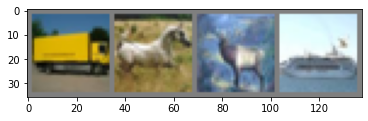

Images of: ['truck', 'horse', 'deer', 'ship']
Size of the image array for a given batch: torch.Size([4, 3, 32, 32])


In [5]:
# get some random training images
dataiter = iter(train_loader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
print('Images of: {}'.format([classes[i] for i in labels]))
print('Size of the image array for a given batch: {}'.format(images.shape))

## Testing the convolutions 

Before implementing the CNN for the image recognition let's see what the convolutions and the pooling layers do the images

Convolution is the first layer to extract features from an input image. It preserves the relationship between pixels by learning images features using small squares of input data. It's a matrix operation that takes two inputs -- image matrix and a filter/kernel

Two main hyper-parameters for the pooling layers: 
1. Stride -- controls how filters 'slides' on the input volume. Stride is normally set in a way so that the output volume is an integer and not a fraction.  Increase the stride if you want receptive fields to overlap less and want smaller spatial dimensions

2. Padding -- 
![CNN architecture](./images/image_matrix.png)
**Image matrix multiplies kernel or filter matrix**

![CNN architecture](./images/output_image_conv.gif)
**3 x 3 Output matrix**


### Calculating the output size of the image after convolutions: 

To calculate the output size of the image after convolution layer: 

$$O = \frac{W - F + 2P}{S} + 1$$

where O is the output height/length, W is the input height/length, F is the filter size, P is the padding, and S is the stride.

## Pooling layers 

Pooling layers section would reduce the number of parameters when the images are too large. Spatial pooling also called subsampling or downsampling which reduces the dimensionality of each map but retains important information. Spatial pooling can be of different types:
1. Max Pooling
2. Average Pooling
3. Sum Pooling

Max pooling takes the largest element from the rectified feature map. Taking the largest element could also take the average pooling. Sum of all elements in the feature map call as sum pooling.

![CNN architecture](./images/pool_scheme.png)
**Max pooling scheme**

In [7]:
conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5, stride=1, padding=0)
pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0) #Take max of the 2x2 array and shift by 2 
conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1, padding=0)

In [8]:
print(images.shape)
x = conv1(images)
print(x.shape)

torch.Size([4, 3, 32, 32])
torch.Size([4, 6, 28, 28])


In [9]:
x = pool(x)
print(x.shape)

torch.Size([4, 6, 14, 14])


In [10]:
x = conv2(x)
print(x.shape)

torch.Size([4, 16, 10, 10])


In [11]:
x = pool(x)
print(x.shape)

torch.Size([4, 16, 5, 5])


### Building the CNN class

In [12]:
class ConvNet(nn.Module):
    '''
    Inherit from the nn.Module all the necessary routines 
    
    super() is in the business of delegating method calls 
    to some class in the instance’s ancestor tree.
    
    Conv1 = First convolution 3 color channels (RGB) to 6 output, 
    filter size=5
    
    pool = Max pool layer of 2x2 and stride of 2 ie. we shift 2 
    pixel to the right after each pooling operations 
    
    Conv2 = Second convolution layer with 6 input channel and 
    16 output channel, filter size of 5 
    
    Full connected layer 
    
    FC1 = Flatten output of the final convolution + pooling (16 * 5 * 5)
    to 120 dim array 
    
    FC2 = 120 to 84 
    FC3 = 84 to no of hidden equal to that of class labels 
    
    Forward operation 
    -----------------------
    images --> conv --> relu --> pool --> conv2 --> relu --> pool
    Flatten pooled output --> FC (w/ relu) --> FC (relu) --> FC --> output
    '''
    def __init__(self):
        super(ConvNet, self).__init__()
        #Here we built the architecture for the CNN
        #First conv1 function instantiation
        self.conv1 = nn.Conv2d(3,6,5) 
        #General purpose pooling 
        self.pool = nn.MaxPool2d(2,2) 
        #Second conv2 function instantiation
        self.conv2 = nn.Conv2d(6,16,5)
        #1st NN layer
        self.fc1 = nn.Linear(16*5*5,120)
        #2nd NN layer 
        self.fc2 = nn.Linear(120,84)
        #Final output layer 
        self.fc3 = nn.Linear(84,10) 
    
    def forward(self, x):
        #Two pooling operations
        x = self.pool(F.relu(self.conv1(x)))  # -> n, 6, 14, 14
        x = self.pool(F.relu(self.conv2(x)))  # -> n, 16, 5, 5
        #Flatten the output from pooling/convoltions
        x = x.view(-1, 16 * 5 * 5)            # -> n, 400
        x = F.relu(self.fc1(x))               # -> n, 120
        x = F.relu(self.fc2(x))               # -> n, 84
        x = self.fc3(x)                       # -> n, 10
        return x

### Defining the training criterion and optmizer 

In [13]:
#Define model, criterion, optimizer for the GD 
model = ConvNet().to(device)
#For multiclass classification -- crossentropy loss 
criterion = nn.CrossEntropyLoss() 
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

### Train the CNN on the test dataset

In [ ]:
n_total_steps = len(train_loader)
for epoch in range(num_epochs):
    for i, (images,labels) in enumerate(train_loader):
        # origin shape: [4, 3, 32, 32] = 4, 3, 1024
        # input_layer: 3 input channels, 6 output channels, 5 kernel size
        images = images.to(device)
        labels = labels.to(device)
        
        #Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        #Backward prop and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i+1) % 2000 == 0: 
            print (f'Epoch [{epoch+1}/{num_epochs}],\
                   Step [{i+1}/{n_total_steps}],\
                   Loss: {loss.item():.4f}')
print('Finished Training')
PATH = './cnn.pth'
torch.save(model.state_dict(), PATH)

In [17]:
with torch.no_grad(): #We dont need backward propogation here
    n_correct = 0
    n_samples = 0
    n_class_correct = [0 for i in range(10)]
    n_class_samples = [0 for i in range(10)]
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        # max returns (value ,index)
        _, predicted = torch.max(outputs, 1)
        n_samples += labels.size(0)
        n_correct += (predicted == labels).sum().item()
        
        for i in range(batch_size):
            label = labels[i]
            pred = predicted[i]
            if (label == pred):
                n_class_correct[label] += 1
            n_class_samples[label] += 1

    acc = 100.0 * n_correct / n_samples
    print(f'Accuracy of the network: {acc} %')

    for i in range(10):
        acc = 100.0 * n_class_correct[i] / n_class_samples[i]
        print(f'Accuracy of {classes[i]}: {acc} %')

Accuracy of the network: 48.28 %
Accuracy of plane: 55.7 %
Accuracy of car: 62.1 %
Accuracy of bird: 26.1 %
Accuracy of cat: 34.2 %
Accuracy of deer: 31.0 %
Accuracy of dog: 33.3 %
Accuracy of frog: 75.1 %
Accuracy of horse: 50.0 %
Accuracy of ship: 58.7 %
Accuracy of truck: 56.6 %
